# Train and Apply Models

In [1]:
from ML.model_training import (
    random_train_test_split,
    train_random_forest,
    train_random_forest_regressor,
    omit_patient,
    train_knn_regressor,
    train_lstm,
    STSNet
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import math, re, itertools
from ML import utils
import sys
from IPython.display import clear_output
from scipy.stats import pearsonr

Generate all subsets of columns for parameters.

In [ ]:
# features = utils.important_features_list(
#     "datasets/USE_feature_importance/dreamer_feature_importance_arousal.csv"
# )
# unique = []
# for i in range(1, len(features)):
#     unique.append(features[:i])

# print("Unique:", unique)
# print(len(unique))

Unique: [['T8_T7_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma', 'AF4_AF3_gamma_ra'], ['T8_T7_gamma_ra', 'T8_T7_gamma_da', 'O2_alpha', 'FC5_gamma', 'F8_alpha', 'P8_alpha', 'O1_alpha', 'FC6_FC5_gamma_ra', 'O1_gamma', 'AF4_AF3_gamma_ra', 'FC6_FC5

In [8]:
#15
X_train, X_test, arousal_train, arousal_test = omit_patient(
    target="arousal", held_out_patient=22
)
features = utils.filter_features(
    X_train.columns,
    remove_bands=["gamma", "delta"]
)
arousal_train = pd.Series(
    np.where(arousal_train > 3.8, "high", "low"),
    index=arousal_train.index,
    dtype="string",
)
arousal_test = pd.Series(
    np.where(arousal_test > 3.8, "high", "low"),
    index=arousal_test.index,
    dtype="string",
)

def balance(X, y, seed=5):
    c = y.value_counts()
    if c.get("high", 0) == c.get("low", 0):
        return X.reset_index(drop=True), y.reset_index(drop=True)
    maj = c.idxmax()
    m = c.min()
    keep = y[y != maj].index.union(y[y == maj].sample(m, random_state=seed).index)
    return X.loc[keep].reset_index(drop=True), y.loc[keep].reset_index(drop=True)


X_train, arousal_train = balance(X_train, arousal_train, seed=5)
X_test, arousal_test = balance(X_test, arousal_test, seed=5)

print("arousal_train counts:\n", arousal_train.value_counts(dropna=False))
print("arousal_test counts:\n", arousal_test.value_counts(dropna=False))

22
arousal_train counts:
 low     5177
high    5177
Name: count, dtype: Int64
arousal_test counts:
 low     563
high    563
Name: count, dtype: Int64


## LSTM LOSO

In [10]:
best_model = None
best_acc = 0
best_keep = None

best_lr = 0
best_f1 = 0
bar_len = 30


def render(bar_str: str, status_str: str, curr):
    print(bar_str)
    print(curr)
    print(status_str, end="")
    sys.stdout.flush()


status = f"Best: index= size= | " f"acc= | f1= | prec= | rec="

results = []

for lr in [0.001, 0.01]:
    for e in [10, 50, 100]:
        for u in [64, 256]:
            for b_s in [32, 256]:
                lstm, X_test_eval, y_test_eval = train_lstm(
                    X_train,
                    X_test,
                    arousal_train,
                    arousal_test,
                    lr=lr,
                    epochs=e,
                    units=u,
                    batch_size=b_s,
                    bidirectional=False,
                )
                y_prob = lstm.predict(X_test_eval).ravel()
                arousal_pred = (y_prob >= 0.5).astype(int)

                acc = accuracy_score(y_test_eval, arousal_pred)
                f1 = f1_score(y_test_eval, arousal_pred, average="weighted")
                prec = precision_score(y_test_eval, arousal_pred, average="weighted")
                rec = recall_score(y_test_eval, arousal_pred, average="weighted")

                if acc > best_acc:
                    best_acc = acc
                    best_model = lstm
                    best_lr = lr
                    best_e = e
                    best_u = u
                    best_b_s = b_s
                    best_f1 = f1
                    best_arousal_pred = arousal_pred
                    status = (
                        f"Best: "
                        f"acc={acc:.6f} | f1={f1:.6f} | prec={prec:.6f} | rec={rec:.6f} | lr={best_lr} | epochs={best_e} | units={best_u} | batch_size={best_b_s}"
                    )
                    print(status)

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_eval, best_arousal_pred))

print("\nClassification Report (pooled):")
print(classification_report(y_test_eval, best_arousal_pred, zero_division=0))

print(status)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best: acc=0.381883 | f1=0.320671 | prec=0.315319 | rec=0.381883 | lr=0.001 | epochs=10 | units=64 | batch_size=32
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best: acc=0.395204 | f1=0.359172 | prec=0.364796 | rec=0.395204 | lr=0.001 | epochs=10 | units=64 | batch_size=256
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best: acc=0.420071 | f1=0.327891 | prec=0.322931 | rec=0.420071 | lr=0.001 | epochs=10 | units=256 | batch_size=32
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best: acc=0.500000 | f1=0.333333 | prec=0.250000 | rec=0.500000 | lr=0.01 | epochs=10 | units=64 | batch_size=32


/Users/tolas/Documents/coding/Tetris-EEG/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Best: acc=0.501776 | f1=0.363381 | prec=0.513617 | rec=0.501776 | lr=0.01 | epochs=10 | units=256 | batch_size=32
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/Users/tolas/Documents/coding/Tetris-EEG/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/Users/tolas/Documents/coding/Tetris-EEG/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Confusion Matrix (pooled):
[[ 20 543]
 [ 18 545]]

Classification Report (pooled):
              precision    recall  f1-score   support

         0.0       0.53      0.04      0.07       563
         1.0       0.50      0.97      0.66       563

    accuracy                           0.50      1126
   macro avg       0.51      0.50      0.36      1126
weighted avg       0.51      0.50      0.36      1126

Best: acc=0.501776 | f1=0.363381 | prec=0.513617 | rec=0.501776 | lr=0.01 | epochs=10 | units=256 | batch_size=32


In [7]:
acc_list = []
f1w_list = []
precw_list = []
recw_list = []
n_list = []

num_folds = 10
y_test_full = []
y_pred_full = []

for fold in range(num_folds):

    while True:
        X_train, X_test, arousal_train, arousal_test = omit_patient(
            target="arousal"
        )
        arousal_train = pd.Series(
            np.where(arousal_train > 3.8, "high", "low"),
            index=arousal_train.index,
            dtype="string",
        )
        arousal_test = pd.Series(
            np.where(arousal_test > 3.8, "high", "low"),
            index=arousal_test.index,
            dtype="string",
        )

        c = arousal_test.value_counts()
        if c.get("high", 0) == 0 or c.get("low", 0) == 0:
            continue


        X_train, arousal_train = balance(X_train, arousal_train)
        X_test, arousal_test = balance(X_test, arousal_test)
        break

    print("arousal_train counts:\n", arousal_train.value_counts(dropna=False))
    print("arousal_test counts:\n", arousal_test.value_counts(dropna=False))


    clf, X_test_eval, y_test_eval = train_lstm(
        X_train, X_test, arousal_train, arousal_test, lr=best_lr, epochs=best_e, units=best_u, batch_size=best_b_s
    )

    y_prob = clf.predict(X_test_eval).ravel()
    y_pred = (y_prob >= 0.5).astype(int)


    acc = accuracy_score(y_test_eval, y_pred)
    f1w = f1_score(y_test_eval, y_pred, average="weighted", zero_division=0)
    prec = precision_score(y_test_eval, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test_eval, y_pred, average="weighted", zero_division=0)

    acc_list.append(float(acc))
    print(acc)
    f1w_list.append(float(f1w))
    precw_list.append(float(prec))
    recw_list.append(float(rec))

    y_test_full.extend(y_test_eval)
    y_pred_full.extend(y_pred.tolist() if hasattr(y_pred, "tolist") else list(y_pred))

# averages across folds
avg_acc = float(np.mean(acc_list)) if acc_list else float("nan")
avg_f1w = float(np.mean(f1w_list)) if f1w_list else float("nan")
avg_prec = float(np.mean(precw_list)) if precw_list else float("nan")
avg_rec = float(np.mean(recw_list)) if recw_list else float("nan")

print("LSTM Classification Performance (cross-subject folds)")
print("---------------------------------------------------")
print(f"Accuracy: {avg_acc:.4f}")
print(f"F1 (weighted): {avg_f1w:.4f}")
print(f"Precision (weighted): {avg_prec:.4f}")
print(f"Recall (weighted): {avg_rec:.4f}")

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_full, y_pred_full))

print("\nClassification Report (pooled):")
print(classification_report(y_test_full, y_pred_full, zero_division=0))

1
arousal_train counts:
 low     19273
high    19273
Name: count, dtype: Int64
arousal_test counts:
 low     772
high    772
Name: count, dtype: Int64
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 
0.49287564766839376
19
arousal_train counts:
 low     19644
high    19644
Name: count, dtype: Int64
arousal_test counts:
 low     700
high    700
Name: count, dtype: Int64
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
0.585
13
arousal_train counts:
 low     19627
high    19627
Name: count, dtype: Int64
arousal_test counts:
 low     717
high    717
Name: count, dtype: Int64
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 
0.5034867503486751
20
arousal_train counts:
 low     19074
high    19074
Name: count, dtype: Int64
arousal_test counts:
 low     573
high    573
Name: count, dtype: Int64


KeyboardInterrupt: 

## STSNet LOSO

In [ ]:
best_model = None
best_acc = 0
best_keep = None

best_lr = 0
best_f1 = 0
bar_len = 30


def render(bar_str: str, status_str: str, curr):
    print(bar_str)
    print(curr)
    print(status_str, end="")
    sys.stdout.flush()


start_at = 49

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

status = f"Best: index= size= | " f"acc= | f1= | prec= | rec="

results = []
for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"

    X_train_sub = X_train.loc[:, keep]
    X_test_sub = X_test.loc[:, keep]

    n_low = (arousal_train == "low").sum()
    n_high = (arousal_train == "high").sum()
    for lr in [0.001]:
        for e in [10, 15, 30]:
            for u in [500, 1000]:
                model, X_test_eval, y_test_eval = STSNet(X_train_sub, arousal_train, X_test_sub, arousal_test)

                y_prob = model.predict(X_test_eval).ravel()
                arousal_pred = (y_prob >= 0.5).astype(int)

                acc = accuracy_score(y_test_eval, arousal_pred)
                f1 = f1_score(y_test_eval, arousal_pred, average="weighted")
                prec = precision_score(y_test_eval, arousal_pred, average="weighted")
                rec = recall_score(y_test_eval, arousal_pred, average="weighted")

                if acc > best_acc:
                    best_acc = acc
                    best_model = lstm
                    best_keep = keep
                    best_lr = lr
                    best_e = e
                    best_u = u
                    best_f1 = f1
                    best_arousal_pred = arousal_pred
                    status = (
                        f"Best: index={idx} size={len(keep)} | "
                        f"acc={acc:.6f} | f1={f1:.6f} | prec={prec:.6f} | rec={rec:.6f} | lr={best_lr} | epochs={best_e} | units={best_u}"
                    )
                    print(status)

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_eval, best_arousal_pred))

print("\nClassification Report (pooled):")
print(classification_report(y_test_eval, best_arousal_pred, zero_division=0))

print(status)

### Train KNN Regressor

In [4]:
def safe_pcc(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return float("nan")
    return float(np.corrcoef(y_true, y_pred)[0, 1])


best_pcc = 0
best_model = None
best_keep = None
best_n = None


bar_len = 30


def render(bar_str: str, status_str: str, curr):
    clear_output(wait=True)
    print(bar_str)
    print(curr)
    print(status_str, end="")
    sys.stdout.flush()


start_at = 40

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

status = f"Best: index= size= | " f"acc= | f1= | prec= | rec= | K="

results = []
for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"

    X_train_sub = X_train.loc[:, keep]
    X_test_sub = X_test.loc[:, keep]

    for n in [1, 3, 6, 9]:
        knn, X_test_eval, y_test_eval = train_knn_regressor(
            X_train_sub, X_test_sub, arousal_train, arousal_test, neighbors=n
        )
        arousal_pred = knn.predict(X_test_eval)

        r2 = r2_score(y_test_eval, arousal_pred)
        mae = mean_absolute_error(y_test_eval, arousal_pred)
        mse = mean_squared_error(y_test_eval, arousal_pred)
        rmse = math.sqrt(mse)
        pcc = safe_pcc(y_test_eval, arousal_pred)

        if abs(pcc) > abs(best_pcc):
            best_pcc = pcc
            best_model = knn
            best_keep = keep
            best_n = n
            status = (
                f"Best: index={idx} size={len(keep)} | "
                f"PCC={pcc:.6f} | R2={r2:.6f} | MAE={mae:.6f} | RMSE={rmse:.6f} | K={best_n}"
            )

    render(bar_str, status, pcc)
render(bar_str, status, pcc)

print(status)
utils.plot_regressor_accuracy(y_test_eval.to_list(), arousal_pred)

[█████████████████████████████-] 48/49 ( 98.0%)
-0.00917245275665438
Best: index=40 size=40 | PCC=0.035445 | R2=-1.238803 | MAE=0.719220 | RMSE=0.901636 | K=1

KeyboardInterrupt: 

### Train RF Regressor

In [11]:
best_model = None
best_mae = math.inf
best_keep = None
best_metrics = {
    "PCC": 0.0,
    "MSE": math.inf,
    "RMSE": math.inf,
    "MAE": math.inf,
    "size": 0,
}


bar_len = 30


def safe_pcc(y_true, y_pred):
    yt = np.asarray(y_true, dtype=float).ravel()
    yp = np.asarray(y_pred, dtype=float).ravel()
    if yt.size < 2 or np.std(yt) == 0 or np.std(yp) == 0:
        return 0.0
    return float(np.corrcoef(yt, yp)[0, 1])


def render(bar_str: str, status_str: str, curr_mae):
    clear_output(wait=True)
    print(bar_str)
    print(curr_mae)
    print(status_str, end="")
    sys.stdout.flush()


status = "Best: size=0 | PCC=0.0000 | MSE=∞ | RMSE=∞ | MAE=∞"

start_at = 49

total_full = len(unique)
iter_unique = unique[start_at - 1 :]

for idx, keep in enumerate(iter_unique, start_at):
    filled = int(bar_len * idx / total_full) if total_full else 0
    bar = "█" * filled + "-" * (bar_len - filled)
    pct = (idx / total_full * 100) if total_full else 100
    bar_str = f"[{bar}] {idx}/{total_full} ({pct:5.1f}%)"


    # arousal_train = pd.Series(
    #         np.where(arousal_train > 3.33, "high", "low"),
    #         index=arousal_train.index,
    #         dtype="string",
    #     )
    # arousal_test = pd.Series(
    #     np.where(arousal_test > 3.33, "high", "low"),
    #     index=arousal_test.index,
    #     dtype="string",
    # )

    rf, X_test_eval, y_test_eval = train_random_forest(
        X_train, X_test, arousal_train, arousal_test
    )

    arousal_pred = rf.predict(X_test_eval)

    acc = accuracy_score(y_test_eval, arousal_pred)
    f1 = f1_score(y_test_eval, arousal_pred, average="weighted")
    prec = precision_score(y_test_eval, arousal_pred, average="weighted")
    rec = recall_score(y_test_eval, arousal_pred, average="weighted")

    best_acc = acc
    best_model = rf
    best_keep = keep
    best_f1 = f1
    best_arousal_pred = arousal_pred
    status = (
        f"Best: index={idx} size={len(keep)} | "
        f"acc={acc:.6f} | f1={f1:.6f} | prec={prec:.6f} | rec={rec:.6f}"
    )
    print(status)

print("\nConfusion Matrix (pooled):")
print(confusion_matrix(y_test_eval, best_arousal_pred))

print("\nClassification Report (pooled):")
print(classification_report(y_test_eval, best_arousal_pred, zero_division=0))

print(status)
# 40076!! low mse
# 40418!! low mae

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.3s


Best: index=49 size=49 | acc=0.525581 | f1=0.519968 | prec=0.526837 | rec=0.525581

Confusion Matrix (pooled):
[[545 315]
 [501 359]]

Classification Report (pooled):
              precision    recall  f1-score   support

        high       0.52      0.63      0.57       860
         low       0.53      0.42      0.47       860

    accuracy                           0.53      1720
   macro avg       0.53      0.53      0.52      1720
weighted avg       0.53      0.53      0.52      1720

Best: index=49 size=49 | acc=0.525581 | f1=0.519968 | prec=0.526837 | rec=0.525581


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.0s finished


**Hyperparameter Tuning**

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min


Random Forest Regression Performance
--------------------------------------------
PCC:  0.7053 (avg p=0)
R²:   0.4695
MAE:  0.583797
MSE:  0.575356
RMSE: 0.758522

Best feature subset
-------------------
Count: 49
T8_T7_gamma_ra, T8_T7_gamma_da, O2_alpha, FC5_gamma
F8_alpha, P8_alpha, O1_alpha, FC6_FC5_gamma_ra
O1_gamma, AF4_AF3_gamma_ra, FC6_FC5_gamma_da, AF4_AF3_gamma_da
T7_gamma, F8_theta, P8_P7_gamma_da, P8_theta
F3_gamma, F8_F7_alpha_ra, P8_P7_gamma_ra, F8_gamma
FC5_alpha, O2_gamma, F8_F7_delta_da, FC6_gamma
F8_F7_theta_ra, FC6_alpha, F8_F7_delta_ra, AF4_alpha
F8_F7_theta_da, F8_F7_alpha_da, O1_theta, AF4_gamma
T8_alpha, F4_F3_gamma_ra, O2_O1_delta_ra, P8_gamma
O2_theta, O2_O1_delta_da, F7_gamma, AF3_gamma
P7_alpha, F4_alpha, F4_F3_alpha_ra, T8_T7_alpha_da
T8_T7_alpha_ra, F3_alpha, T8_theta, F4_F3_alpha_da
FC5_theta


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.1s finished


<Axes: xlabel='y_true', ylabel='y_pred'>

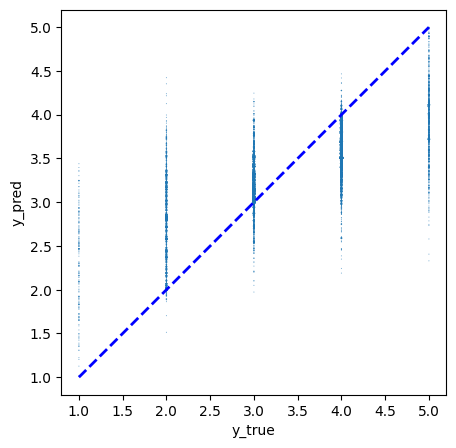

In [12]:
pcc_list = []
pval_list = []
r2_list = []
mae_list = []
mse_list = []
rmse_list = []
n_list = []

best_cross_val_mae = math.inf

num_folds = 1

for fold in range(num_folds):
    X_train, X_test, arousal_train, arousal_test = random_train_test_split(
        target="arousal",
    )

    X_train_sub = X_train.loc[:, best_keep]
    X_test_sub = X_test.loc[:, best_keep]

    rf, X_test_eval, y_test_eval = train_random_forest_regressor(
        X_train_sub,
        X_test_sub,
        arousal_train,
        arousal_test
    )

    y_pred = rf.predict(X_test_eval)

    r2 = r2_score(y_test_eval, y_pred)
    mae = mean_absolute_error(y_test_eval, y_pred)
    mse = mean_squared_error(y_test_eval, y_pred)
    rmse = float(np.sqrt(mse))

    try:
        from scipy.stats import pearsonr

        pcc, pval = pearsonr(
            np.asarray(y_test_eval).ravel(), np.asarray(y_pred).ravel()
        )
    except Exception:
        yt = np.asarray(y_test_eval, dtype=float).ravel()
        yp = np.asarray(y_pred, dtype=float).ravel()
        if yt.size < 2 or np.std(yt) == 0 or np.std(yp) == 0:
            pcc, pval = 0.0, float("nan")
        else:
            pcc = float(np.corrcoef(yt, yp)[0, 1])
            pval = float("nan")


    pcc_list.append(float(pcc))
    pval_list.append(float(pval))
    r2_list.append(float(r2))
    mae_list.append(float(mae))
    mse_list.append(float(mse))
    rmse_list.append(float(rmse))

avg_pcc = float(np.mean(pcc_list))
avg_pval = float(np.mean(pval_list))
avg_r2 = float(np.mean(r2_list))
avg_mae = float(np.mean(mae_list))
avg_mse = float(np.mean(mse_list))
avg_rmse = float(np.mean(rmse_list))

if len(n_list) > 0:
    final_n = n_list[0]
else:
    final_n = "N/A"

print("Random Forest Regression Performance")
print("--------------------------------------------")
print(f"PCC:  {avg_pcc:.4f} (avg p={avg_pval:.3g})")
print(f"R²:   {avg_r2:.4f}")
print(f"MAE:  {avg_mae:.6f}")
print(f"MSE:  {avg_mse:.6f}")
print(f"RMSE: {avg_rmse:.6f}")

print("\nBest feature subset")
print("-------------------")
print(f"Count: {len(best_keep)}")
wrap = 4
for i in range(0, len(best_keep), wrap):
    print(", ".join(best_keep[i : i + wrap]))

utils.plot_regressor_accuracy(y_test_eval.to_list(), y_pred)